# Advanced Natural Lanugage Processing

## Pre-trained BERT and RoBERTa-models

In [1]:
# General working tools
import numpy as np
import pandas as pd
import os
import scipy

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Useful ML Tools
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [149]:
parentdir = "C:\\Users\Joakim Torsvik\Downloads\MSc Data Science\Advanced NLP\Week 2 - N-grams\sentence-completion"
test_data = pd.read_csv(os.path.join(parentdir, 'testing_data.csv'),index_col=0)
test_answer = pd.read_csv(os.path.join(parentdir, 'test_answer.csv'),index_col=0).iloc[:,0]

## BERT and RoBERTa

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [39]:
answers = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e'}

def get_options_indices(tokenizer, prefix, options):
    
    """Converting options' text into id of the tokenizer
    Args:
    - tokenizer: PretrainedTokenizer
    - options: list
    Return: indices of each option's text (list)"""
    
    indices = [tokenizer(option)['input_ids'][1:-1] for option in options]
    for i, option in enumerate(options):
        if prefix + option in tokenizer.vocab.keys():
            indices[i] = [tokenizer.convert_tokens_to_ids(prefix+option)]
    return indices

cos = nn.CosineSimilarity(dim=0, eps=1e-6)

class pretrained_model_tester():
    
    def __init__(self, test_df, model_checkpoint):
        self.tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
        self.model = AutoModelForMaskedLM.from_pretrained(model_checkpoint).to(device)
        self.model.eval()
        self.test_data = test_df.copy()
        # RoBERTa
        if 'roberta' in model_checkpoint:
            self.test_data.question = self.test_data.question.str.replace('_____', '<mask>')
            self.embedding_weight = self.model.roberta.embeddings.word_embeddings.weight
            self.prefix = 'Ġ' 
        else: # BERT
            self.test_data.question = self.test_data.question.str.replace('_____', '[MASK]')
            self.embedding_weight = self.model.bert.embeddings.word_embeddings.weight
            self.prefix = ''

    def predict(self, question, options, result_method, pooling_method):
        
        """Perform sentence splitting, tokenizing, applying model and get result.
        Args:
        - question: string
            text with masked token
        - options: list of string
            option to be chosen
        - result_method: string
            `base_only` (use only the first token of the option) or `all` (use every token)
        - pooling_method: string
            `sum` (summing all the embedding of tokens together) or `mean` (averaging all the embedding of tokens together)
        Return: index of the option chosen (int)"""
        
        # tokenizing
        inputs = self.tokenizer(question,return_tensors='pt')
        # move to gpu if available
        inputs = {key: value.to(device) for key, value in inputs.items()}
        # misc
        masked_index = np.where((inputs['input_ids'] == self.tokenizer.mask_token_id).cpu())[1][0]
        options_indices = get_options_indices(self.tokenizer, self.prefix, options)
        
        # get result
        with torch.no_grad():
            outputs = self.model(**inputs)[0]
            if result_method == 'base_only':
                options_indices = [option[0] for option in options_indices]
                outputs=outputs[:, masked_index, options_indices]
                return torch.argmax(outputs).item(), np.array(outputs)[0]
            
            elif result_method == 'all':
                predicted_index = torch.argmax(outputs[0, masked_index]).item()
                predicted_embedding = self.embedding_weight[predicted_index,:]
                similarity = []
                
                for indices in options_indices:
                    if pooling_method == 'mean':
                        similarity.append(cos(predicted_embedding,self.embedding_weight[indices,:].mean(axis=0)).item())
                    
                    elif pooling_method == 'max':
                        similarity.append(cos(predicted_embedding,self.embedding_weight[indices,:].max(axis=0)[0]).item())
                    
                    elif pooling_method == 'min':
                        similarity.append(cos(predicted_embedding,self.embedding_weight[indices,:].min(axis=0)[0]).item())
                    
                    else:
                        raise TypeError('pooling_method must be `mean`, `max` or `min` when result_method is `all`')
                return np.argmax(similarity), np.array(similarity)
            else:
                raise TypeError('result_method must be either `base_only` or `all`')
    
    def batch_predict(self, result_method, pooling_method='sum'):
        
        """ Perform prediction on the whole test df

        Arguments:
        - result_method: string
            `base_only` (use only the first token of the option) or `all` (use every token)
        - pooling_method: string
            `sum` (summing all the embedding of tokens together) or `mean` (averaging all the embedding of tokens together)

        Return: answers of the questions (pandas series)"""
        
        result = []
        all_preds = []
        for index, row in self.test_data.iterrows():
            question = row[0]
            options = row[1:].tolist()
            predicted_ind, predictions = self.predict(question, options, result_method, pooling_method)
            result.append(answers[predicted_ind])
            all_preds.append(predictions)
        return pd.Series(result, index=test_data.index), pd.Series(all_preds, index=test_data.index)

def get_accuracy(prediction, labels):
    return sum(prediction==labels) / len(labels)

In [42]:
params = {'model_checkpoints': ['bert-base-uncased', 'bert-base-cased', 'bert-large-uncased',
                                'bert-large-cased', 'roberta-base', 'roberta-large'],
          'result_method':['base_only', 'all'],
          'pooling_method':['max', 'min', 'mean']}

In [43]:
res = []
all_predictions = []

for checkpoint in params['model_checkpoints']:
    pretrained_model = pretrained_model_tester(test_data, checkpoint)
    for method in params['result_method']:
        if method == 'base_only':
            predictions, all_preds = pretrained_model.batch_predict(method, None)
            res.append([checkpoint, method, None, round(get_accuracy(predictions, test_answer) * 100, 3)])
            all_predictions.append(all_preds)
        else:
            for pool in params['pooling_method']:
                predictions, all_preds = pretrained_model.batch_predict(method, pool)
                res.append([checkpoint, method, pool, round(get_accuracy(predictions, test_answer) * 100, 3)])
                all_predictions.append(all_preds)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model f

In [230]:
result = pd.DataFrame(res, columns=['model_checkpoints', 'result_method', 'pooling_method', 'accuracy'])
display(result)

,model_checkpoints,result_method,pooling_method,accuracy
0,bert-base-uncased,base_only,None,75.000
1,bert-base-uncased,all,max,49.038
2,bert-base-uncased,all,min,45.192
3,bert-base-uncased,all,mean,47.500
4,bert-base-cased,base_only,None,70.192
5,bert-base-cased,all,max,52.692
6,bert-base-cased,all,min,54.904
7,bert-base-cased,all,mean,55.000
8,bert-large-uncased,base_only,None,78.846
9,bert-large-uncased,all,max,53.942


<AxesSubplot:xlabel='model_checkpoints'>

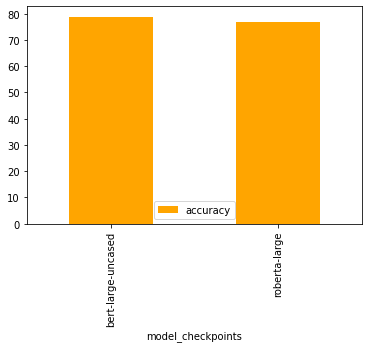

In [264]:
result.iloc[[8, 20]].plot.bar(x='model_checkpoints', y='accuracy', color='orange')

The two best performing models are the ***large, uncased BERT*** and the ***large RoBERTa***. Let's compare the results from these two. First I want to extract the predictions from these two models.

In [296]:
preds = pd.DataFrame(np.array(all_predictions)[[8, 20]], index=result['model_checkpoints'].iloc[[8, 20]]).transpose()
preds.rename(columns={'bert-large-uncased':'bert', 'roberta-large':'roberta'}, inplace=True)
preds.head()

model_checkpoints,bert,roberta
0,"[0.77451825, -6.463148, 7.653578, -2.294808, 7...","[50.684612, 38.211086, 58.9898, 50.202072, 56...."
1,"[-4.147023, 3.2802274, -1.8816494, -4.5027246,...","[48.49562, 53.062046, 48.574924, 46.047962, 55..."
2,"[0.097667314, 2.1758933, 3.1693223, 8.405982, ...","[51.145363, 52.572147, 47.3882, 56.167118, 39...."
3,"[-0.85072356, 4.1159883, 15.790798, 1.5753299,...","[43.752407, 47.866486, 63.273304, 47.514767, 4..."
4,"[2.4967327, 7.2874427, 3.972897, 15.980728, -0...","[48.99263, 51.783737, 47.79437, 61.866062, 42...."


In [297]:
bert = preds['bert'].values
roberta = preds['roberta'].values

Changing the letter-values of the answers with their index values corresponding

In [256]:
ans = test_answer.copy()

for k, v in answers.items():
    ans.replace(v, k, inplace=True)
ans = ans.values

Creating lists which show where each model answered correct or incorrect

In [257]:
bert_preds = [1 if ans[i] == np.argmax(bert[i]) else 0 for i in range(len(ans))]
roberta_preds = [1 if ans[i] == np.argmax(roberta[i]) else 0 for i in range(len(ans))]

# Just to test if it is correct
print(sum(bert_preds) / len(bert_preds))
print(sum(roberta_preds) / len(roberta_preds))

0.7884615384615384
0.7673076923076924


They still have the same accuracy.

Now, let's look at how many questions they answered similar to.

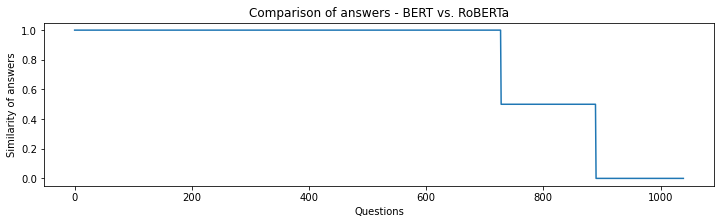

70.0 % predictions correct by both models.
15.576923076923077 % predictions correct by only one model.
14.423076923076922 % predictions incorrect by both models.


In [336]:
comparison = [(bert_preds[i] + roberta_preds[i])/2 for i in range(len(bert_preds))]

plt.figure(figsize=(12, 3))
plt.plot(range(len(bert_preds)), sorted(comparison, reverse=True))
plt.title("Comparison of answers - BERT vs. RoBERTa")
plt.xlabel("Questions")
plt.ylabel("Similarity of answers")
plt.show()

print(f"{sum([1 for i in comparison if i == 1])/len(comparison) * 100} % predictions correct by both models.")
print(f"{sum([1 for i in comparison if i == 0.5])/len(comparison) * 100} % predictions correct by only one model.")
print(f"{sum([1 for i in comparison if i == 0])/len(comparison) * 100} % predictions incorrect by both models.")

Looking at the questions it looks like the sentences are ambiguous and could easily be mistaken by different language models

In [340]:
for i, j in enumerate(comparison):
    if j == 0:
        print(test_data.values[i])
        print(f"BERT: {np.argmax(bert[i])}")
        print(f"RoBERTa: {np.argmax(roberta[i])}")
        print(f"Correct answer: {test_answer[i]}")
        print("")

['It was furnished partly as a sitting and partly as a bedroom , with flowers arranged _____ in every nook and corner.'
 'daintily' 'privately' 'inadvertently' 'miserably' 'comfortably']
BERT: 4
RoBERTa: 4
Correct answer: c

['There is no _____ between them , but they all open out into the same corridor.'
 'understanding' 'communication' 'difference' 'intrigue' 'issue']
BERT: 2
RoBERTa: 2
Correct answer: b

['I can distinctly remember that as we did so there came three _____ from a neighboring clock.'
 'batters' 'cheers' 'centuries' 'fiddlers' 'chimes']
BERT: 1
RoBERTa: 1
Correct answer: d

['You can imagine my _____ , Watson , when within two inches of my peg I saw a conical depression in the ground.'
 'virtue' 'seamanship' 'occupation' 'exultation' 'ankles']
BERT: 2
RoBERTa: 2
Correct answer: a

['Was he our _____ enemy , or was he by chance our guardian angel.'
 'consecrated' 'pedantic' 'malignant' 'cheerful' 'splendid']
BERT: 0
RoBERTa: 4
Correct answer: e

['He lay back without __